<img src="../../files/logo.png" width="40%"  align="left">

# Getting started with OGGM: Öztal case study

The OGGM workflow is best explained with an example. We are going to use the case we use for testing the oggm codebase. The test files are located in a dedicated online repository, [oggm-sample-data](https://github.com/OGGM/oggm-sample-data).

## Input data

In the `test-workflow` directory you can have a look at the various files we will need. oggm also needs them for testing, so they are automatically available to everybody with a simple mechanism:

In [1]:
from oggm.utils import get_demo_file
srtm_f = get_demo_file('srtm_oeztal.tif')
rgi_f = get_demo_file('rgi_oeztal.shp')
print(srtm_f)

ImportError: No module named 'oggm'

The very first time that you make a call to `get_demo_file()`, oggm will create a hidden `.oggm` directory in your home folder$^*$ and download the demo files in it.

<sub>*: this path might vary depending on your platform, see python's [expanduser](https://docs.python.org/3.5/library/os.path.html#os.path.expanduser)</sub>. 

### DEM and glacier outlines

The data directory contains a subset of the RGI V4 for the Öztal:

In [2]:
import salem  # https://github.com/fmaussion/salem
rgi_shp = salem.utils.read_shapefile(rgi_f).set_index('RGIID')

NameError: name 'rgi_f' is not defined

We'll have a look at it, but first we will need to make some imports and set some stuffs:

In [12]:
# Plot defaults
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# Packages
import os
import cleo  # https://github.com/fmaussion/cleo
import shapely.geometry as shpg
plt.rcParams['figure.figsize'] = (8, 8)  # Default plot size
# Set the default logger 
import logging
logging.basicConfig(format='%(asctime)s: %(name)s: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S', level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

Plot the glaciers of the Öztal case study:

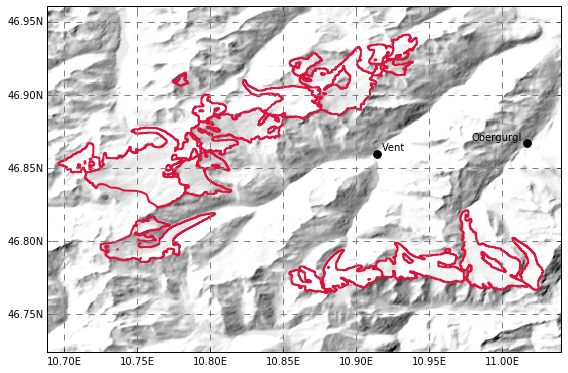

In [13]:
# Open the DEM file
dem = salem.GeoTiff(srtm_f)
# Center the map on the region of interest
dem.set_subset(margin=-80)
cmap = cleo.Map(dem.grid, countries=False)
cmap.set_topography(dem.get_vardata())
# Add a reference point for Vent and Obergurgl
cmap.set_geometry(shpg.Point(10.913889, 46.859444), facecolor='k', text='Vent')
cmap.set_geometry(shpg.Point(11.016667, 46.866667), facecolor='k', text='Obergurgl', 
                  text_delta=(-0.01, 0.01), text_kwargs={'horizontalalignment':'right'})
# Plot the RGI file
cmap.set_shapefile(rgi_f, edgecolor='crimson', linewidth=2, label='RGI')
cmap.visualize()

### WGMS and GlaThiDa 

These are 19 selected glaciers where we have either mass-balance data (WGMS) or volume information (GlaThiDa). These data are required for calibration/validation and are also available from the test directory:

In [14]:
import pandas as pd
df_gtd = pd.read_csv(get_demo_file('RGI_GLATHIDA_oeztal.csv'))
df_wgms = pd.read_csv(get_demo_file('RGI_WGMS_oeztal.csv'))

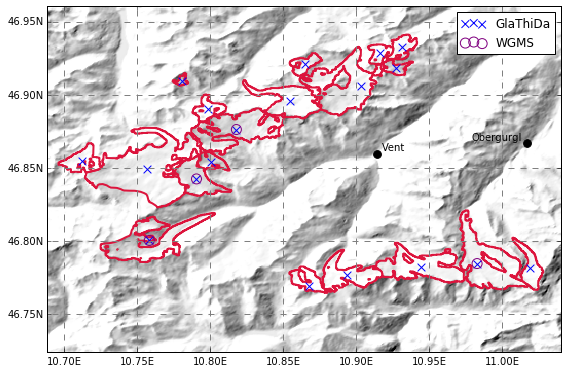

In [15]:
x, y = rgi_shp.loc[df_gtd.RGI_ID].CENLON, rgi_shp.loc[df_gtd.RGI_ID].CENLAT
cmap.set_points(x, y, marker='x', c='blue', label='GlaThiDa')
x, y = rgi_shp.loc[df_wgms.RGI_ID].CENLON, rgi_shp.loc[df_wgms.RGI_ID].CENLAT
cmap.set_points(x, y, marker='o', s=100, facecolor='none', edgecolor='purple', label='WGMS')
cmap.visualize()
plt.legend();

### Climate data

We use HISTALP data (which goes back further in time than CRU), stored in the NetCDF format:

In [16]:
nc = salem.GeoNetcdf(get_demo_file('HISTALP_oeztal.nc'))
t2 = np.mean(nc.get_vardata('temp'), axis=0)
cmap.set_data(t2, nc.grid)
cmap.set_cmap(plt.get_cmap('viridis'))
cmap.set_nlevels(256)
cmap.visualize()

AttributeError: NetCDF: Write to read only

The resolution of HISTALP (5 minutes of arc) is quite high, but you can see that some kind of downscaling will be necessary to compute the mass-balance at the glacier scale.

We can also plot a timeseries of the data, for example for the grid point (3, 3):

In [17]:
fig = plt.figure(figsize=(9, 3))
title = 'Temp at point (3, 3), altitude {}m'.format(nc.get_vardata('hgt')[3, 3])
pd.Series(nc.get_vardata('temp')[:, 3, 3], index=nc.time).resample('A').plot(title=title);

NameError: name 'nc' is not defined

## Setting up an OGGM run

OGGM parameters are gathered in a configuration file. The [default file](https://github.com/OGGM/oggm/blob/master/oggm/params.cfg) is shipped with the code. It is used to initialize the configuration module:

In [18]:
import oggm
from oggm import cfg
from oggm import workflow
cfg.initialize()  # read the default parameter file

For example, the `cfg` module has a global variable `PATHS` (a dictionary) storing the file paths to the data and working directories:

In [21]:
print(cfg.PATHS)

OrderedDict([('working_dir', '/Users/oberrauch/OGGM_wd'), ('topo_dir', '~'), ('cru_dir', '~'), ('dem_file', '/Users/oberrauch/.oggm/oggm-sample-data-master/test-workflow/srtm_oeztal.tif'), ('climate_file', '/Users/oberrauch/.oggm/oggm-sample-data-master/test-workflow/HISTALP_oeztal.nc'), ('wgms_rgi_links', '/Users/oberrauch/.oggm/oggm-sample-data-master/test-workflow/RGI_WGMS_oeztal.csv'), ('glathida_rgi_links', '/Users/oberrauch/.oggm/oggm-sample-data-master/test-workflow/RGI_GLATHIDA_oeztal.csv')])


The path to the input data files are missing. Let's set them so that the oggm modules know where to look for them:

In [20]:
cfg.PATHS['dem_file'] = get_demo_file('srtm_oeztal.tif')
cfg.PATHS['climate_file'] = get_demo_file('HISTALP_oeztal.nc')
cfg.PATHS['wgms_rgi_links'] = get_demo_file('RGI_WGMS_oeztal.csv')
cfg.PATHS['glathida_rgi_links'] = get_demo_file('RGI_GLATHIDA_oeztal.csv')
# This is the database for the glacier divides (currently only Hintereisferner):
cfg.set_divides_db(get_demo_file('HEF_divided.shp'))

We keep the other parameters to their default values, for example the precipitation scaling factor:

In [22]:
print(cfg.PARAMS['prcp_scaling_factor'])

2.5


## Glacier working directories

An OGGM "run" is made of several successive tasks to be applied on each glacier. Because these tasks can be computationally expensive they are split in smaller tasks, each of them storing their results in a [glacier directory](http://oggm.readthedocs.org/en/latest/glacierdir-gen.html).

The very first task of an OGGM run is always `init_glacier_regions`:

In [23]:
# Read in the RGI file
import geopandas as gpd
rgi_file = get_demo_file('rgi_oeztal.shp')
rgidf = gpd.GeoDataFrame.from_file(rgi_file)
# Initialise directories
# reset=True will ask for confirmation if the directories are already present: 
# this is very useful if you don't want to loose hours of computations because of a single command
gdirs = oggm.workflow.init_glacier_regions(rgidf, reset=True)

Delete all glacier directories? [Y/n] Y


Note that if I run `init_glacier_regions` a second time without `reset=True`, nothing special happens. The directories will not be overwritten, just "re-opened":

In [24]:
gdirs = workflow.init_glacier_regions(rgidf)

Now what is the variable `gdirs`? It is a list of 19 [GlacierDirectory](http://oggm.readthedocs.org/en/latest/generated/oggm.GlacierDirectory.html#oggm.GlacierDirectory) objects. They are here to help us to handle data I/O and to store several glacier properties. Here are some examples: 

In [25]:
gdir = gdirs[13]
print('Directory containing the glacier data:', gdir.dir)
print('RGI identifier:', gdir.rgi_id)
print('RGI outline date:', gdir.rgi_date)
print('RGI glacier area in km2:', gdir.rgi_area_km2)
print('OGGM glacier grid size in m:', gdir.grid.dx)

Directory containing the glacier data: /Users/oberrauch/OGGM_wd/per_glacier/RGI40-11.00887
RGI identifier: RGI40-11.00887
RGI outline date: 2003-07-01 00:00:00
RGI glacier area in km2: 8.938
OGGM glacier grid size in m: 55.0


`gdir` provides a `get_filepath` function which gives access to the data files present in the directory:

In [26]:
gdir.get_filepath('dem')

'/Users/oberrauch/OGGM_wd/per_glacier/RGI40-11.00887/dem.tif'

`dem.tif` is a local digital elevation map with a spatial resolution chosen by OGGM as a function of the glacier size. These [GlacierDirectory](http://oggm.readthedocs.org/en/latest/generated/oggm.GlacierDirectory.html#oggm.GlacierDirectory) objects are going to be the input of almost every OGGM task.

This data model has been chosen so that even complex functions requires serval input data can be called with one single argument: 

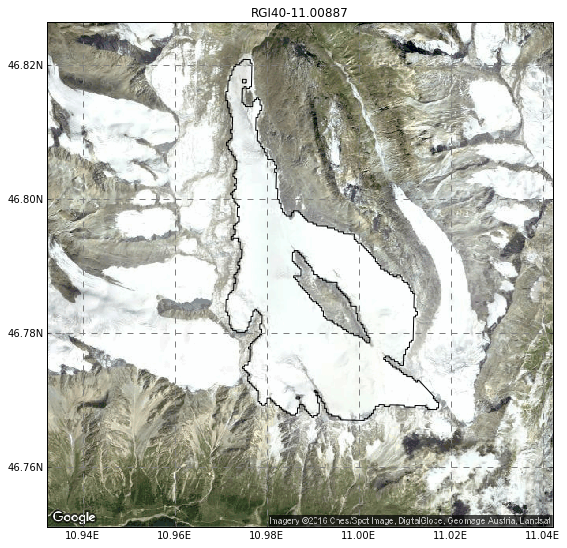

In [27]:
from oggm import graphics
graphics.plot_googlemap(gdir)

## OGGM tasks

The workflow of OGGM is oriented around the concept of "[tasks](http://oggm.readthedocs.org/en/latest/api.html#entity-tasks)". There are two different types:

**Entity Task**:
  Standalone operations to be realized on one single glacier entity,
  independently from the others. The majority of OGGM
  tasks are entity tasks. They are parallelisable.

**Global Task**:
  tasks which require to work on several glacier entities
  at the same time. Model parameter calibration or interpolation of degree day factors belong to
  this type of task. They are not parallelisable.
  
OGGM implements a simple mechanism to run a specific task on a list of `GlacierDir` objects (here, the function `glacier_masks()` from the module `oggm.prepro.gis`):

In [28]:
from oggm import tasks 

In [29]:
# run the glacier_masks task on all gdirs
workflow.execute_entity_task(tasks.glacier_masks, gdirs)

We just computed gridded boolean [masks](http://oggm.readthedocs.org/en/latest/generated/oggm.tasks.glacier_masks.html#oggm.tasks.glacier_masks) out of the RGI outlines.

It is also possible to apply several tasks sequentially:

In [30]:
list_talks = [
         tasks.compute_centerlines,
         tasks.compute_downstream_lines,
         tasks.catchment_area,
         tasks.initialize_flowlines,
         tasks.catchment_width_geom,
         tasks.catchment_width_correction
         ]
for task in list_talks:
    workflow.execute_entity_task(task, gdirs)

The function `execute_task` can run a task on different glaciers at the same time, if the `use_multiprocessing` option is set to `True` in the configuration file. 

With all these tasks we just computed the glacier flowlines and their width:

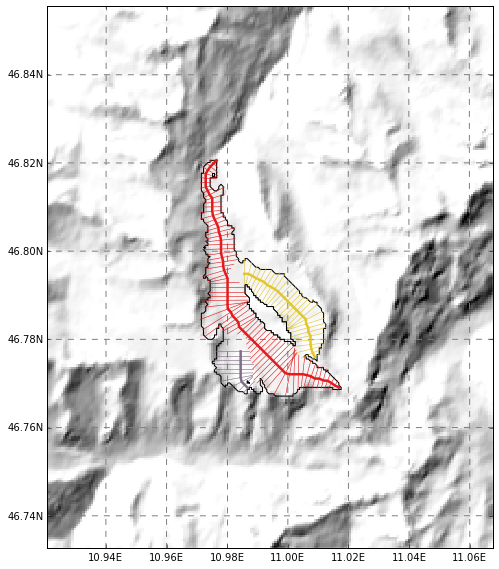

In [31]:
graphics.plot_catchment_width(gdir)

### Global tasks, climate tasks

We will go into more detail about tasks and global tasks when I have more time to write a good documentation. For now, we will use the helper function:

In [32]:
workflow.climate_tasks(gdirs)

We just read the climate data, "downscaled" it to each glacier, computed possible $\mu^*$ for the reference glaciers, picked the best one, interpolated the corresponding $t^*$ to glaciers without mass-balance observations, computed the mass-balance sensitivity $\mu$ for all glaciers and finally computed the mass-balance at equilibrium (the "apparent mb" in Farinotti et al., 2009).

Finally, we will prepare the data for the inversion, which is an easy:

In [33]:
workflow.execute_entity_task(tasks.prepare_for_inversion, gdirs)

## Inversion

This is where things become a bit more complicated. The inversion is already fully automated in OGGM, but for this tutorial we will try to explain in more detail what is happening.

Let's start with the funcion `invert_parabolic_bed`:

In [34]:
from oggm.core.preprocessing.inversion import invert_parabolic_bed

This function will compute the ice thickness along the flowline. It has one free parameter (or too, if you also want to consider the basal sliding term in the inversion): Glen's deformation parameter A. Let's compute the bed inversion for Hintereisferner and the default A: 

In [35]:
# Select HEF out of all glaciers
gdir_hef = [gd for gd in gdirs if (gd.rgi_id == 'RGI40-11.00897')][0]

In [36]:
glen_a = cfg.A
vol_m3, area_m3 = invert_parabolic_bed(gdir_hef, glen_a=glen_a)
print('With A={}, the mean thickness of HEF is {:.1f} m'.format(glen_a, vol_m3/area_m3))

With A=2.4e-24, the mean thickness of HEF is 88.5 m


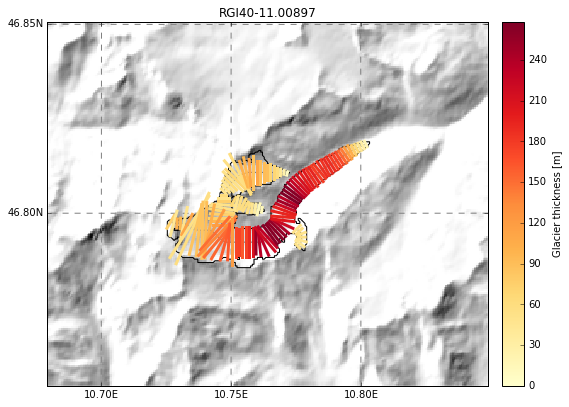

In [37]:
graphics.plot_inversion(gdir_hef)

We know from the literature (Fisher et al, 2013) that the HEF should have an average thickness of 67$\pm$7 m. How sensitive is the inversion to changes in the A parameter?

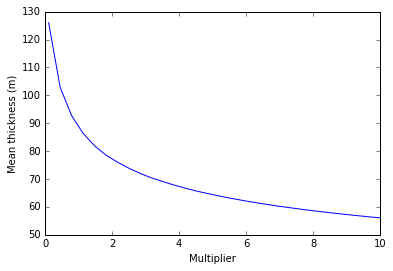

In [39]:
factor = np.linspace(0.1, 10, 30)
thick = factor*0
for i, f in enumerate(factor):
    vol_m3, area_m3 = invert_parabolic_bed(gdir_hef, glen_a=glen_a*f)
    thick[i] = vol_m3/area_m3
plt.figure(figsize=(6, 4))
plt.plot(factor, thick);
plt.ylabel('Mean thickness (m)');
plt.xlabel('Multiplier');

The A parameter controls the deformation of the ice, and therefore the thickness. It is always possible to find a "perfect" A for each glacier with measurements, for example by using an optimisation function. The current way to deal with this in OGGM is to use all glaciers with a volume estimate from the GLaThiDa database, and define A so that the **volume RMSD** is minimized. The reason for choosing the volume (which is strongly affected by the area) over the thickness is that with this method, larger glaciers will have more influence on the final results.

In [40]:
optim_resuls = tasks.optimize_inversion_params(gdirs)

The `optimize_inversion_params` task also writes some statistics in the working directory:

In [41]:
fpath = os.path.join(cfg.PATHS['working_dir'], 'inversion_optim_results.csv')
df = pd.read_csv(fpath, index_col=0)
df['ref_thick'] = df['ref_volume_km3'] / df['ref_area_km2'] * 1e3
df['oggm_thick'] = df['oggm_volume_km3'] / df['ref_area_km2'] * 1e3
df['vas_thick'] = df['vas_volume_km3'] / df['ref_area_km2'] * 1e3

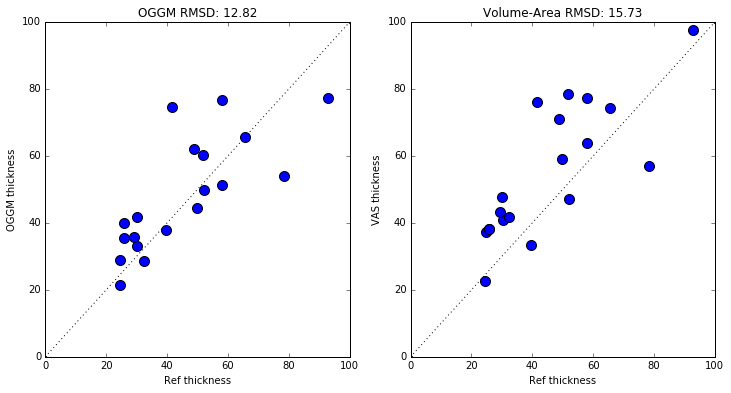

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(df['ref_thick'], df['oggm_thick'], s=100)
ax1.set_title('OGGM RMSD: {:.2f}'.format(oggm.utils.rmsd(df['ref_thick'], df['oggm_thick'])))
ax1.set_xlabel('Ref thickness')
ax1.set_ylabel('OGGM thickness')
ax1.plot([0, 100], [0, 100], '.:k', zorder=0);
ax1.set_xlim([0, 100]), ax1.set_ylim([0, 100]);
ax2.scatter(df['ref_thick'], df['vas_thick'], s=100)
ax2.set_title('Volume-Area RMSD: {:.2f}'.format(oggm.utils.rmsd(df['ref_thick'], df['vas_thick'])))
ax2.set_xlabel('Ref thickness')
ax2.set_ylabel('VAS thickness')
ax2.plot([0, 100], [0, 100], '.:k', zorder=0);
ax2.set_xlim([0, 100]), ax2.set_ylim([0, 100]);

In [43]:
#TODO: try more inversion things here

## Flowline model

All the previous steps are necessary to run the flowline model: the computation of the flowline(s) and their width, the interpolation of the climate data, the mass-balance sensitivity $\mu$, an estimate of the glacier bed...

All this data are stored in the glacier directories. For example for HEF the data should be approx 2.2 Mb. You can explore the various files available in the directory printed below:

In [44]:
print(gdir_hef.dir)

/Users/oberrauch/OGGM_wd/per_glacier/RGI40-11.00897


The files are partly documented [here](http://oggm.readthedocs.org/en/latest/glacierdir-gen.html#cfg-basenames).

The first task to apply before using the model is the ``init_present_time_glacier`` function:

In [45]:
tasks.init_present_time_glacier(gdir_hef)

This task is required to merge the various glacier divides back together and to allow the glacier to grow by adding the downstream flowlines. This function also decides on the [shape](http://oggm.readthedocs.org/en/latest/flowline.html#glacier-bed-shapes) of the glacier bed along the flowlines and downstream (currently an "average" parabolic shape is chosen). Let's initialize our model with this geometry:

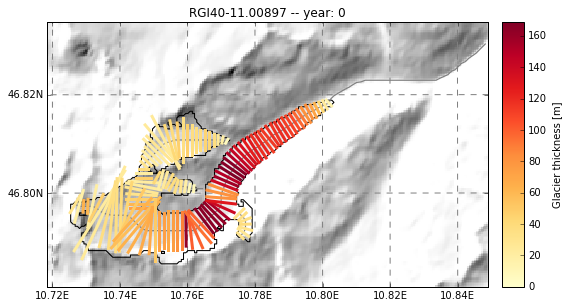

In [88]:
from oggm.core.models.flowline import FluxBasedModel
# the flowlines alone
fls = gdir_hef.read_pickle('model_flowlines')
model = FluxBasedModel(fls)
graphics.plot_modeloutput_map(gdir_hef, model=model);

A cross-section along the glacier can be visualized with the following function:

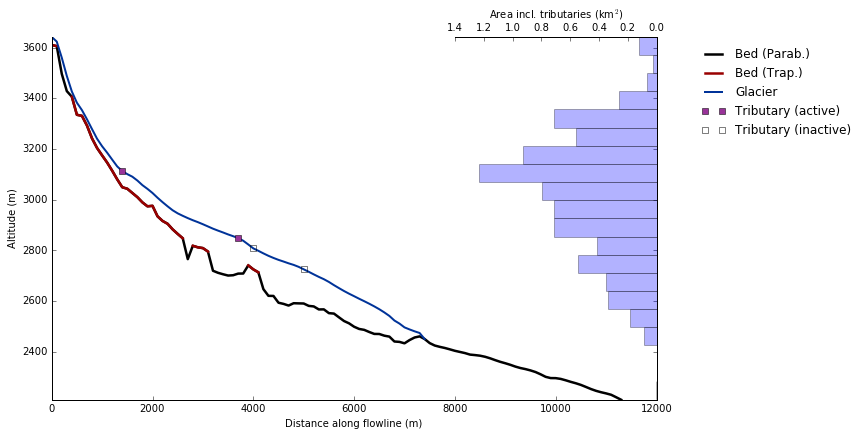

In [89]:
graphics.plot_modeloutput_section(gdir, model=model);

In [95]:
print(model.fls)
print(model.fls[1].bed_shape[0])
model.fls[1].bed_shape[0] = 0.004
print(model.fls[1].bed_shape[0])

[<oggm.core.models.flowline.MixedFlowline object at 0x1161b8da0>, <oggm.core.models.flowline.MixedFlowline object at 0x1161d72e8>, <oggm.core.models.flowline.MixedFlowline object at 0x1175269b0>, <oggm.core.models.flowline.MixedFlowline object at 0x1161c5588>, <oggm.core.models.flowline.MixedFlowline object at 0x1161d7400>]
10.0
0.004


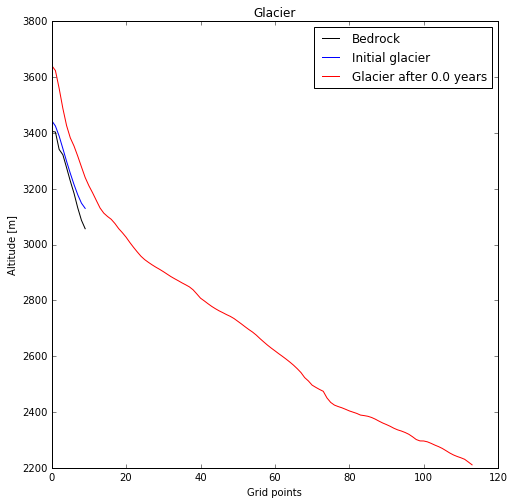

In [101]:
init_flowline_tmp = model.fls[0]
# Plot the initial conditions first:
plt.plot(init_flowline_tmp.bed_h, color='k', label='Bedrock')
plt.plot(init_flowline_tmp.surface_h, color='b', label='Initial glacier')
# The get the modelled flowline (model.fls[-1]) and plot it's new surface
plt.plot(model.fls[-1].surface_h, color='r', label='Glacier after {} years'.format(model.yr))
plt.title('Glacier')
plt.xlabel('Grid points')
plt.ylabel('Altitude [m]')
plt.legend(loc='best');

### Mass balance

To run the model, one has to define a mass-balance function. They are implemented in the [massbalance](http://oggm.readthedocs.org/en/latest/api.html#mass-balance) module:

In [ ]:
from oggm.core.models.massbalance import TodayMassBalanceModel, TstarMassBalanceModel
from oggm.core.models.massbalance import BackwardsMassBalanceModel, HistalpMassBalanceModel 

For example, let's have a look at the mass-balance profile of HEF for the last 30 years, at the period $t^*$, and for the year 2003:

In [ ]:
today_model = TodayMassBalanceModel(gdir_hef)
tstar_model = TstarMassBalanceModel(gdir_hef)
hist_model = HistalpMassBalanceModel(gdir_hef)

In [ ]:
# Altitude of the main flowline:
z = model.fls[-1].surface_h
# Get the mass balance and convert to m per year
mb_today = today_model.get_mb(z) * cfg.SEC_IN_YEAR * cfg.RHO / 1000.
mb_tstar = tstar_model.get_mb(z) * cfg.SEC_IN_YEAR * cfg.RHO / 1000.
mb_2003 = hist_model.get_mb(z, 2003) * cfg.SEC_IN_YEAR * cfg.RHO / 1000.
# Plot
plt.figure(figsize=(8, 5))
plt.plot(mb_today, z, '*', label='Today');
plt.plot(mb_tstar, z, '*', label='t*');
plt.plot(mb_2003, z, '*', label='2003');
plt.ylabel('Altitude (m)');
plt.xlabel('Annual MB (m we)');
plt.legend(loc='best');

### Define a model run

For a complete run you need to specify an initial state, a mass-balance model and the ice-flow parameter(s):

In [ ]:
fls = gdir_hef.read_pickle('model_flowlines')
commit_model = FluxBasedModel(fls, mb_model=today_model, glen_a=cfg.A)

It is now possible to run the model for any period of time:

In [ ]:
# Run for 50 years
commit_model.run_until(50)
graphics.plot_modeloutput_section(gdir_hef, model=commit_model)

Or until an equilibrium is reached (in this case it is possible because the mass-balance is constant in time):

In [ ]:
commit_model.run_until_equilibrium()
graphics.plot_modeloutput_section(gdir_hef, model=commit_model)

In [ ]:
graphics.plot_modeloutput_map(gdir_hef, model=commit_model)

This is a very good example of how surprising glaciers can be. Let's redo this run and store the glacier evolution with time:

In [ ]:
# Reinitialize the model (important!)
fls = gdir_hef.read_pickle('model_flowlines')
commit_model = FluxBasedModel(fls, mb_model=today_model, glen_a=cfg.A)
# Run and store
years = np.arange(200) * 2
volume = np.array([])
for y in years:
    commit_model.run_until(y)
    volume = np.append(volume, commit_model.volume_m3)
# Plot
plt.figure(figsize=(8, 5))
plt.plot(years, volume)
plt.ylabel('Volume (m3)');
plt.xlabel('Time (years)');

How important is the A parameter for the equilibrium volume?

In [ ]:
# Reinitialize the model (important!)
fls = gdir_hef.read_pickle('model_flowlines')
commit_model_08 = FluxBasedModel(fls, mb_model=today_model, glen_a=cfg.A*0.8)
fls = gdir_hef.read_pickle('model_flowlines')
commit_model_10 = FluxBasedModel(fls, mb_model=today_model, glen_a=cfg.A)
fls = gdir_hef.read_pickle('model_flowlines')
commit_model_12 = FluxBasedModel(fls, mb_model=today_model, glen_a=cfg.A*1.2)
# Run and store
years = np.arange(200) * 2
volume_08 = np.array([])
volume_10 = np.array([])
volume_12 = np.array([])
for y in years:
    commit_model_08.run_until(y)
    volume_08 = np.append(volume_08, commit_model_08.volume_m3)
    commit_model_10.run_until(y)
    volume_10 = np.append(volume_10, commit_model_10.volume_m3)
    commit_model_12.run_until(y)
    volume_12 = np.append(volume_12, commit_model_12.volume_m3)
# Plot
plt.figure(figsize=(8, 5))
plt.plot(years, volume_08, label='0.8 A')
plt.plot(years, volume_10, label='1.0 A')
plt.plot(years, volume_12, label='1.2 A')
plt.ylabel('Volume (m3)');
plt.xlabel('Time (years)');
plt.legend(loc='best');

### Historical runs 

Now this is where it becomes interesting. Let's define a run with "real" mass-balance time-series. Let's assume that the 1850 glacier geometry is the same as today's, and run the model over 153 years:

In [ ]:
# Reinitialize the model (important!)
fls = gdir_hef.read_pickle('model_flowlines')
# Same as before with another mass-balance model and a real starting year y0:
model = FluxBasedModel(fls, mb_model=hist_model, glen_a=cfg.A, y0=1850)  
# Run and store
years = np.arange(153) + 1851
volume = np.array([])
for y in years:
    model.run_until(y)
    volume = np.append(volume, model.volume_m3)
# Plot
plt.figure(figsize=(8, 5))
plt.plot(years, volume)
plt.ylabel('Volume (m3)');
plt.xlabel('Time (years)');

Today's HEF would probably be too small to be in equilibrium with the climate during most of the simulation period. The time it needs to re-adjust depends on the glacier characteristics as well as A. We need a way to make our glacier grow first, so that it can shrink as we expect it to do.

In [ ]:
# Reinitialize the model (important!)
fls = gdir_hef.read_pickle('model_flowlines')
# Grow model: current climate, but we add a cold bias
# the bias is in unit of tenths of Kelvin colder (strange unit I know, I have to change this)
mb_model = BackwardsMassBalanceModel(gdir_hef, bias=120)
grow_model = FluxBasedModel(fls, y0=0, mb_model=mb_model, glen_a=cfg.A)
# run until equilibrium
grow_model.run_until_equilibrium()
# plot
graphics.plot_modeloutput_map(gdir_hef, model=grow_model)

Ok. Now reinitialize the historical run with this new input and see:

In [ ]:
# Reinitialize the model with the new geom
fls = grow_model.fls
model = FluxBasedModel(fls, mb_model=hist_model, glen_a=cfg.A, y0=1850)  
# Run and store
years = np.arange(153) + 1851
volume = np.array([])
for y in years:
    model.run_until(y)
    volume = np.append(volume, model.volume_m3)
# Plot
plt.figure(figsize=(8, 5))
plt.plot(years, volume)
plt.ylabel('Volume (m3)');
plt.xlabel('Time (years)');

Looks better! But still not perfect:

In [ ]:
graphics.plot_modeloutput_map(gdir_hef, model=model)

There's still a lot to do!